In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 定義 Haversine 距離公式 ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # 地球半徑 (公尺)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# --- 2. 讀取與整理資料 ---
df_status = pd.read_csv('../data/raw/station_status.csv', sep='\t')
df_info = pd.read_csv('../data/raw/station_info.csv', sep='\t', encoding='utf-8')

# 欄位清理
df_status.columns = df_status.columns.str.strip()
df_info.columns = df_info.columns.str.strip()
df_status['station_no'] = df_status['station_no'].astype(str)
df_info['station_no'] = df_info['station_no'].astype(str)
df_mrt = df_mrt.rename(columns={'經度': 'lng', '緯度': 'lat', 'StationPositionLat': 'lat', 'StationPositionLon': 'lng'})

# --- 3. 計算空間距離 (關鍵特徵) ---
print("計算每個站點離 MRT 的距離中")
yb_coords = df_info[['lat', 'lng']].to_numpy()
mrt_coords = df_mrt[['lat', 'lng']].to_numpy()
min_distances = []
for yb_lat, yb_lng in yb_coords:
    dists = haversine_distance(yb_lat, yb_lng, mrt_coords[:,0], mrt_coords[:,1])
    min_distances.append(np.min(dists))
df_info['dist_to_mrt'] = min_distances

# --- 4. 合併與特徵工程 ---
df_merged = pd.merge(df_status, df_info, on='station_no', how='left')
df_merged['total_spaces'] = pd.to_numeric(df_merged['total_spaces'], errors='coerce')
df_merged['filling_rate'] = df_merged['bikes_available'] / df_merged['total_spaces'] # 滿車率
df_merged['record_time'] = pd.to_datetime(df_merged['record_time'])
df_merged['hour'] = df_merged['record_time'].dt.hour
df_merged['is_weekday'] = df_merged['record_time'].dt.dayofweek < 5 

# 只取平日 + 去除空值 (確保統計準確)
df_analysis = df_merged[df_merged['is_weekday'] == True].dropna(subset=['filling_rate', 'dist_to_mrt', 'district'])

print(f"分析樣本數: {len(df_analysis):,} 筆 (已篩選平日資料)")

計算每個站點離 MRT 的距離中
分析樣本數: 3,216,170 筆 (已篩選平日資料)


[Part A ] 敘述統計：營運健康度與穩定性分析

1. 時段別營運結構比較表：


,平均滿車率,中位數,標準差,變異係數 (CV),嚴重缺車率 (<10%),嚴重滿載率 (>90%)
全時段 (All),36.30%,0.3200,0.2737,0.7539,21.35%,3.91%
尖峰 (Peak),36.06%,0.3103,0.2818,0.7815,22.84%,5.29%
離峰 (Off-Peak),36.38%,0.3226,0.2709,0.7447,20.86%,3.45%



2. 各行政區統計摘要 (依平均滿車率排序)：


,mean,std,CV
district,,,
萬華區,0.385518,0.266800,0.692055
北投區,0.378934,0.258768,0.682883
士林區,0.378867,0.248071,0.654770
大安區,0.373604,0.300754,0.805008
大同區,0.369157,0.280681,0.760328


/var/folders/dj/7jjzq_h56x9dgx01j64qw7lc0000gn/T/ipykernel_25690/1563797218.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='district', y='filling_rate', data=df_clean, order=sorted_districts, palette="viridis", ax=axes[1], showfliers=False) # showfliers=False 隱藏極端值點，讓圖更乾淨


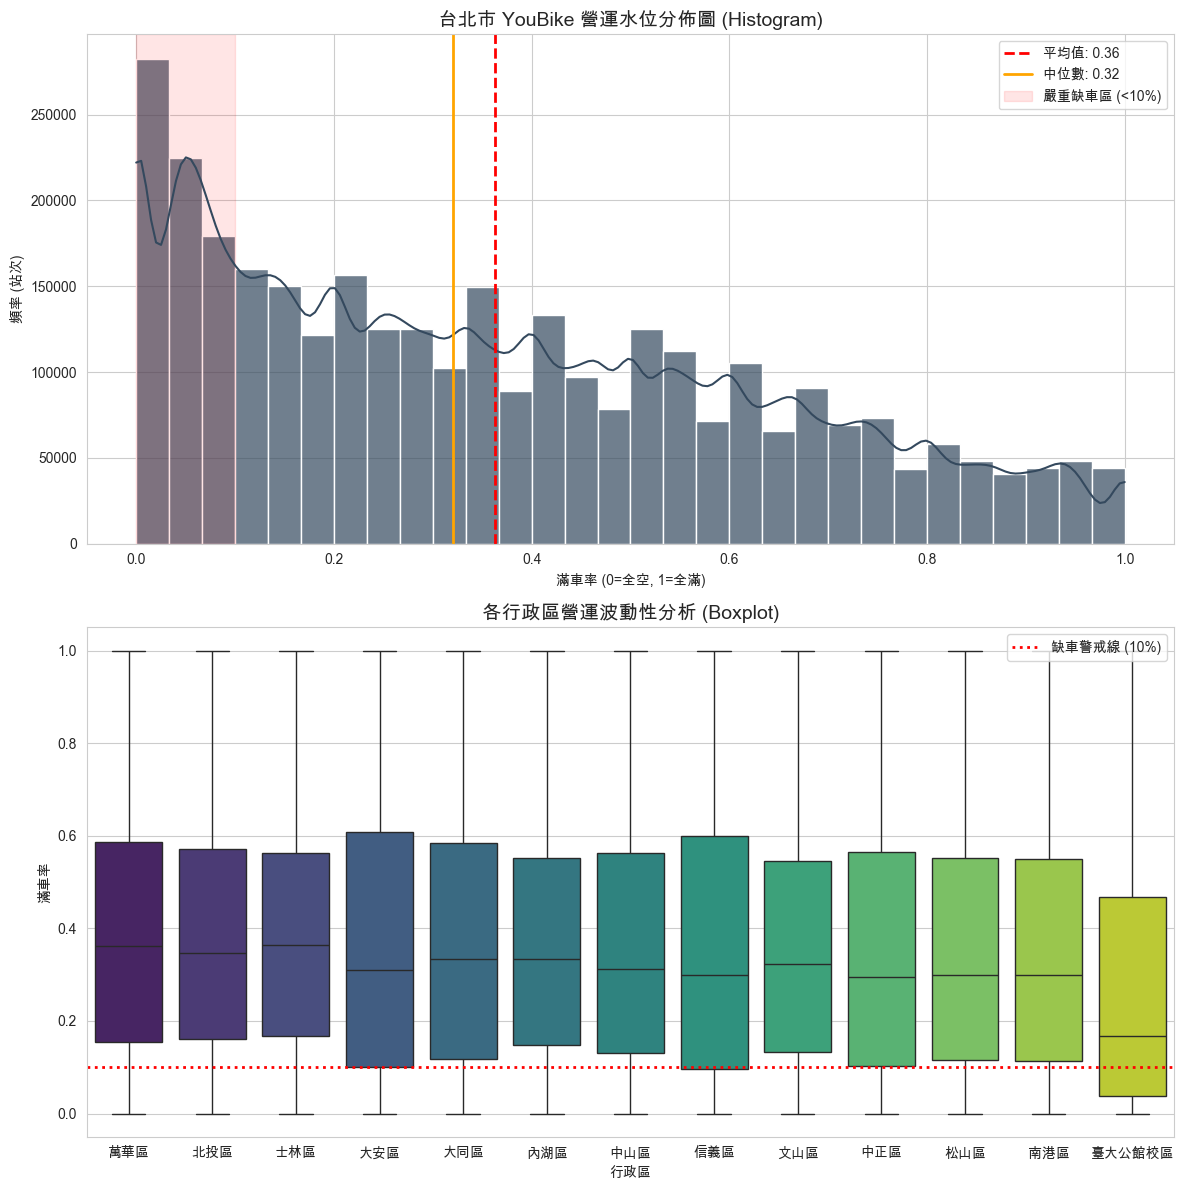

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("[Part A ] 敘述統計：營運健康度與穩定性分析")

# --- 1. 資料清洗 (Data Cleaning) ---
df_clean = df_analysis[df_analysis['filling_rate'] <= 1.0].copy()

# --- 2. 總體結構分析 (含 Peak/Off-Peak 比較) ---
# 定義尖峰時段 (早7-9, 晚17-19)
df_clean['is_peak'] = df_clean['hour'].isin([7,8,9, 17,18,19])

def get_stats_summary(data, label):
    desc = data.describe()
    # 營運風險指標
    shortage_rate = (data < 0.1).mean()
    full_rate = (data > 0.9).mean()
    # 變異係數 (CV) = 標準差 / 平均值 (衡量不穩定程度)
    cv = desc['std'] / desc['mean'] if desc['mean'] != 0 else 0
    
    return pd.Series({
        '平均滿車率': desc['mean'],
        '中位數': desc['50%'],
        '標準差': desc['std'],
        '變異係數 (CV)': cv,
        '嚴重缺車率 (<10%)': shortage_rate,
        '嚴重滿載率 (>90%)': full_rate
    }, name=label)

# 比較 全體 vs 尖峰 vs 離峰
summary_table = pd.DataFrame([
    get_stats_summary(df_clean['filling_rate'], '全時段 (All)'),
    get_stats_summary(df_clean[df_clean['is_peak']]['filling_rate'], '尖峰 (Peak)'),
    get_stats_summary(df_clean[~df_clean['is_peak']]['filling_rate'], '離峰 (Off-Peak)')
])

print("\n1. 時段別營運結構比較表：")
# 格式化輸出：百分比顯示 %，數字顯示 4 位小數
display(summary_table.style.format("{:.2%}", subset=['平均滿車率', '嚴重缺車率 (<10%)', '嚴重滿載率 (>90%)']).format("{:.4f}", subset=['中位數', '標準差', '變異係數 (CV)']))


# --- 3. 行政區穩定性分析 ---
district_stats = df_clean.groupby('district')['filling_rate'].agg(['mean', 'std'])
district_stats['CV'] = district_stats['std'] / district_stats['mean']
district_stats = district_stats.sort_values(by='mean', ascending=False)

print("\n2. 各行政區統計摘要 (依平均滿車率排序)：")
display(district_stats.head())


# --- 4. 雙重視覺化 (直方圖 + 箱型圖) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 圖一：總體分佈直方圖 (Histogram) - 看整體形狀
sns.histplot(df_clean['filling_rate'], bins=30, kde=True, color='#34495e', alpha=0.7, ax=axes[0])
# 加上平均線與中位數
axes[0].axvline(df_clean['filling_rate'].mean(), color='red', linestyle='--', linewidth=2, label=f"平均值: {df_clean['filling_rate'].mean():.2f}")
axes[0].axvline(df_clean['filling_rate'].median(), color='orange', linestyle='-', linewidth=2, label=f"中位數: {df_clean['filling_rate'].median():.2f}")
# 加上警戒區
axes[0].axvspan(0, 0.1, color='red', alpha=0.1, label='嚴重缺車區 (<10%)')
axes[0].set_title('台北市 YouBike 營運水位分佈圖 (Histogram)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('滿車率 (0=全空, 1=全滿)')
axes[0].set_ylabel('頻率 (站次)')
axes[0].legend()

# 圖二：行政區箱型圖 (Boxplot) - 比較各區差異
# 根據「平均滿車率」排序，讓圖表由高到低排列，更專業
sorted_districts = district_stats.index.tolist()
sns.boxplot(x='district', y='filling_rate', data=df_clean, order=sorted_districts, palette="viridis", ax=axes[1], showfliers=False) # showfliers=False 隱藏極端值點，讓圖更乾淨

axes[1].set_title('各行政區營運波動性分析 (Boxplot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('行政區')
axes[1].set_ylabel('滿車率')
# 標示缺車警戒線
axes[1].axhline(0.1, color='red', linestyle=':', linewidth=2, label='缺車警戒線 (10%)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

行政區績效檢定：森林圖分析


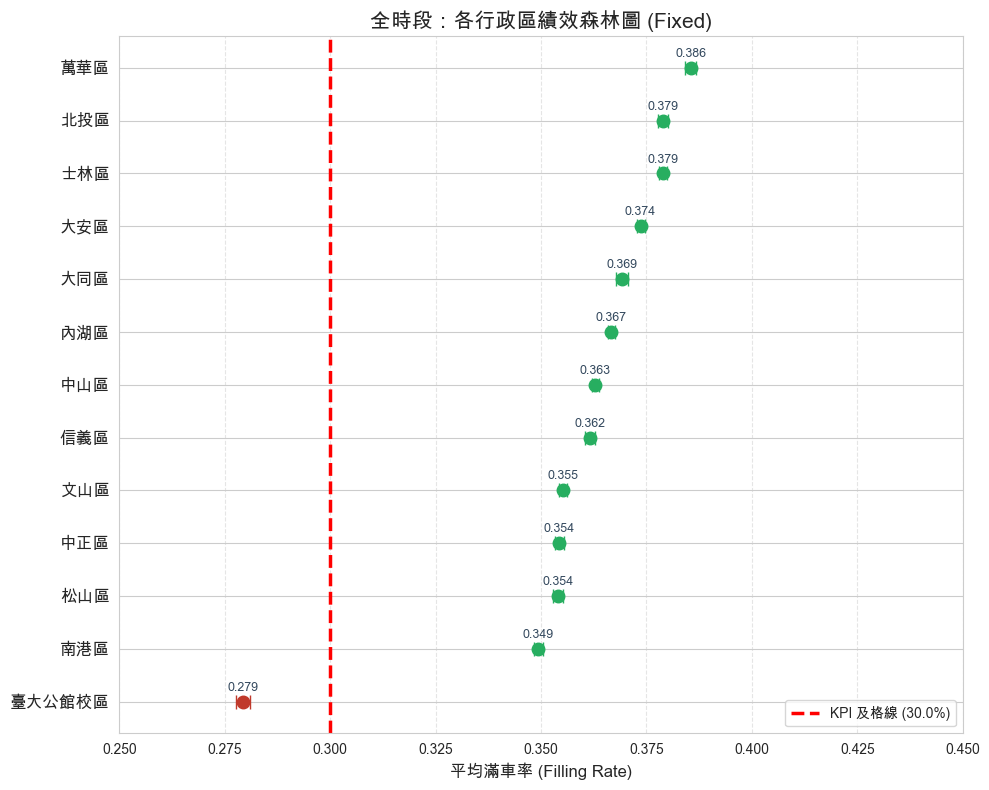

1.相對弱勢區：
數據顯示「臺大公館校區」的平均滿車率最低 (Mean=0.279)。
該區顯著不及格

2.營運最佳：
「萬華區」表現最強 (Mean=0.386)。


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("行政區績效檢定：森林圖分析")
print("="*60)

# --- 1. 資料準備 (使用全時段資料) ---
df_reset = df_analysis.copy()
df_reset = df_reset[df_reset['filling_rate'] <= 1.0]

KPI_TARGET = 0.30 
CONFIDENCE_LEVEL = 0.95

districts = df_reset['district'].unique()
district_results = []

for dist in districts:
    data = df_reset[df_reset['district'] == dist]['filling_rate']
    mean_val = data.mean()
    sem = stats.sem(data)
    ci = stats.t.interval(CONFIDENCE_LEVEL, len(data)-1, loc=mean_val, scale=sem)
    
    # 判定狀態
    if ci[0] > KPI_TARGET:
        status = 'Pass (Green)'
    elif ci[1] < KPI_TARGET:
        status = 'Fail (Red)'
    else:
        status = 'Warning (Orange)'

    district_results.append({
        'District': dist,
        'Mean': mean_val,
        'CI_Lower': ci[0],
        'CI_Upper': ci[1],
        'Status': status
    })

# --- 排序後必須重置索引  ---
# 這樣 i 才會變成 0, 1, 2... 
df_forest_final = pd.DataFrame(district_results).sort_values(by='Mean', ascending=True).reset_index(drop=True)

# --- 2. 視覺化 ---
plt.figure(figsize=(10, 8))

# 畫 KPI 線
plt.axvline(KPI_TARGET, color='red', linestyle='--', linewidth=2.5, label=f'KPI 及格線 ({KPI_TARGET*100}%)')

# 繪製誤差棒
# 使用 enumerate 確保 y 軸座標是 0, 1, 2...
for i, row in df_forest_final.iterrows():
    if row['Status'] == 'Pass (Green)':
        color = '#27ae60' 
    elif row['Status'] == 'Fail (Red)':
        color = '#c0392b' 
    else:
        color = '#f39c12' 
    
    # 這裡的 y=i 是 0, 1, 2... 跟下面的 yticks 對齊
    plt.errorbar(x=row['Mean'], y=i, xerr=[[row['Mean']-row['CI_Lower']], [row['CI_Upper']-row['Mean']]], 
                 fmt='o', markersize=9, capsize=5, linewidth=2, color=color, ecolor=color)
    
    plt.text(row['Mean'], i + 0.15, f"{row['Mean']:.3f}", ha='center', va='bottom', fontsize=9, color='#34495e')

# 設定 Y 軸標籤
plt.yticks(range(len(df_forest_final)), df_forest_final['District'], fontsize=12)

plt.title(f'全時段：各行政區績效森林圖 (Fixed)', fontsize=15, fontweight='bold')
plt.xlabel('平均滿車率 (Filling Rate)', fontsize=12)
plt.xlim(0.25, 0.45) 
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --- 3. 結論 ---
best = df_forest_final.iloc[-1] # 最後一行 (最高分)
worst = df_forest_final.iloc[0] # 第一行 (最低分)

print(f"1.相對弱勢區：")
print(f"數據顯示「{worst['District']}」的平均滿車率最低 (Mean={worst['Mean']:.3f})。")
if worst['Mean'] < 0.3:
    print("該區顯著不及格")
else:
    print("注意：該區雖然達標，但為全系統水位最低者。")

print(f"\n2.營運最佳：")
print(f"「{best['District']}」表現最強 (Mean={best['Mean']:.3f})。")

[Part C] 兩獨立樣本 T 檢定
【統計原理說明】
定義：比較「臺大公館校區」與鄰近的「大安區」在平日尖峰時刻的滿車率差異。
目的：驗證「校園型站點」是否具有結構性的車輛流失特徵，導致其績效顯著低於周邊商業區。
------------------------------------------------------------
【假設檢定設定】
• 虛無假設 (H0): μ_校園 = μ_商業區 (兩者營運水位無差異)
• 對立假設 (H1): μ_校園 < μ_商業區 (校園區顯著缺車)
• 信心水準: 95% (alpha = 0.05)
   分析樣本：
   1. 實驗組：臺大公館校區 (n=27,469)
   2. 對照組：大安區 (n=97,335)

 檢定結果：
   校園組 (臺大) 平均滿車率: 0.300 (30.0%)
   商業組 (大安) 平均滿車率: 0.377 (37.7%)
   差異 (校園-商業): -0.077
   P-value: 2.53806e-304
   Cohen's d: -0.2485


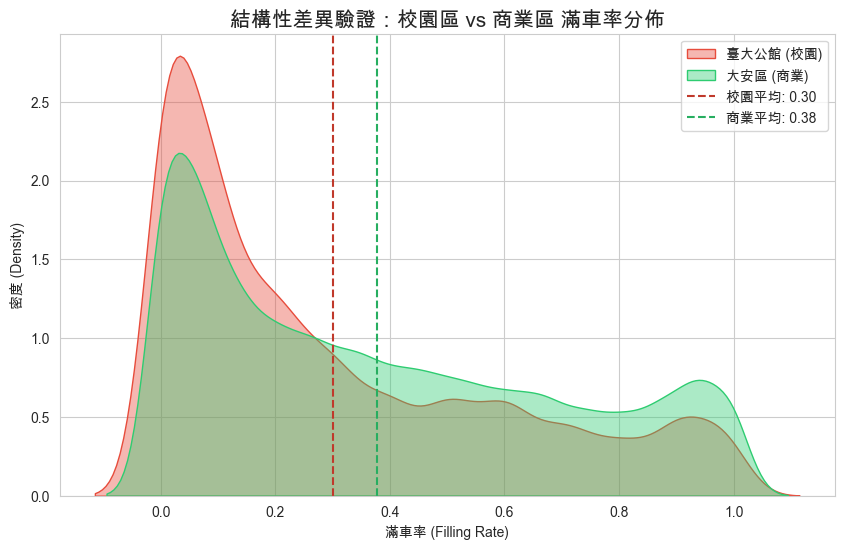

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("[Part C] 兩獨立樣本 T 檢定")
print("="*60)

# --- 1. 研究方法論述 ---
print("【統計原理說明】")
print("定義：比較「臺大公館校區」與鄰近的「大安區」在平日尖峰時刻的滿車率差異。")
print("目的：驗證「校園型站點」是否具有結構性的車輛流失特徵，導致其績效顯著低於周邊商業區。")
print("-" * 60)
print("【假設檢定設定】")
print("• 虛無假設 (H0): μ_校園 = μ_商業區 (兩者營運水位無差異)")
print("• 對立假設 (H1): μ_校園 < μ_商業區 (校園區顯著缺車)")
print("• 信心水準: 95% (alpha = 0.05)")
print("="*60)

# --- 2. 資料鎖定：平日尖峰 (壓力測試) ---
# 我們只看平日尖峰 (通勤/通學最繁忙的時候)
df_stress = df_analysis[
    (df_analysis['record_time'].dt.dayofweek < 5) & 
    (df_analysis['hour'].isin([7, 8, 9, 17, 18, 19]))
].copy()

# 定義兩組
group_school = df_stress[df_stress['district'] == '臺大公館校區']['filling_rate']
group_business = df_stress[df_stress['district'] == '大安區']['filling_rate']

print(f"   分析樣本：")
print(f"   1. 實驗組：臺大公館校區 (n={len(group_school):,})")
print(f"   2. 對照組：大安區 (n={len(group_business):,})")

# --- 3. 執行檢定 ---
# T-test
t_stat, p_val = stats.ttest_ind(group_school, group_business, equal_var=False)

# Cohen's d
def calculate_cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_se

d_val = calculate_cohens_d(group_school, group_business)

# --- 4. 輸出數據 ---
mean_school = group_school.mean()
mean_biz = group_business.mean()

print(f"\n 檢定結果：")
print(f"   校園組 (臺大) 平均滿車率: {mean_school:.3f} ({(mean_school)*100:.1f}%)")
print(f"   商業組 (大安) 平均滿車率: {mean_biz:.3f} ({(mean_biz)*100:.1f}%)")
print(f"   差異 (校園-商業): {mean_school - mean_biz:.3f}")
print(f"   P-value: {p_val:.5e}")
print(f"   Cohen's d: {d_val:.4f}")

# --- 5. 視覺化：分佈密度圖 (KDE Plot) ---
# 用 KDE 圖可以看到兩個山峰的重疊程度，非常直觀
plt.figure(figsize=(10, 6))

sns.kdeplot(group_school, fill=True, color='#e74c3c', label='臺大公館 (校園)', alpha=0.4)
sns.kdeplot(group_business, fill=True, color='#2ecc71', label='大安區 (商業)', alpha=0.4)

# 畫平均線
plt.axvline(mean_school, color='#c0392b', linestyle='--', label=f'校園平均: {mean_school:.2f}')
plt.axvline(mean_biz, color='#27ae60', linestyle='--', label=f'商業平均: {mean_biz:.2f}')

plt.title('結構性差異驗證：校園區 vs 商業區 滿車率分佈', fontsize=15, fontweight='bold')
plt.xlabel('滿車率 (Filling Rate)')
plt.ylabel('密度 (Density)')
plt.legend()
plt.show()



 [Part G ] 行政區解碼
AI 自動命名 (校準後)：
   Cluster 0 (Peak: 07:00) -> 住宅/晨間型
   Cluster 1 (Peak: 05:00) -> 混合/常態型
   Cluster 2 (Peak: 14:00) -> 商業/日間型
   Cluster 3 (Peak: 04:00) -> 混合/常態型


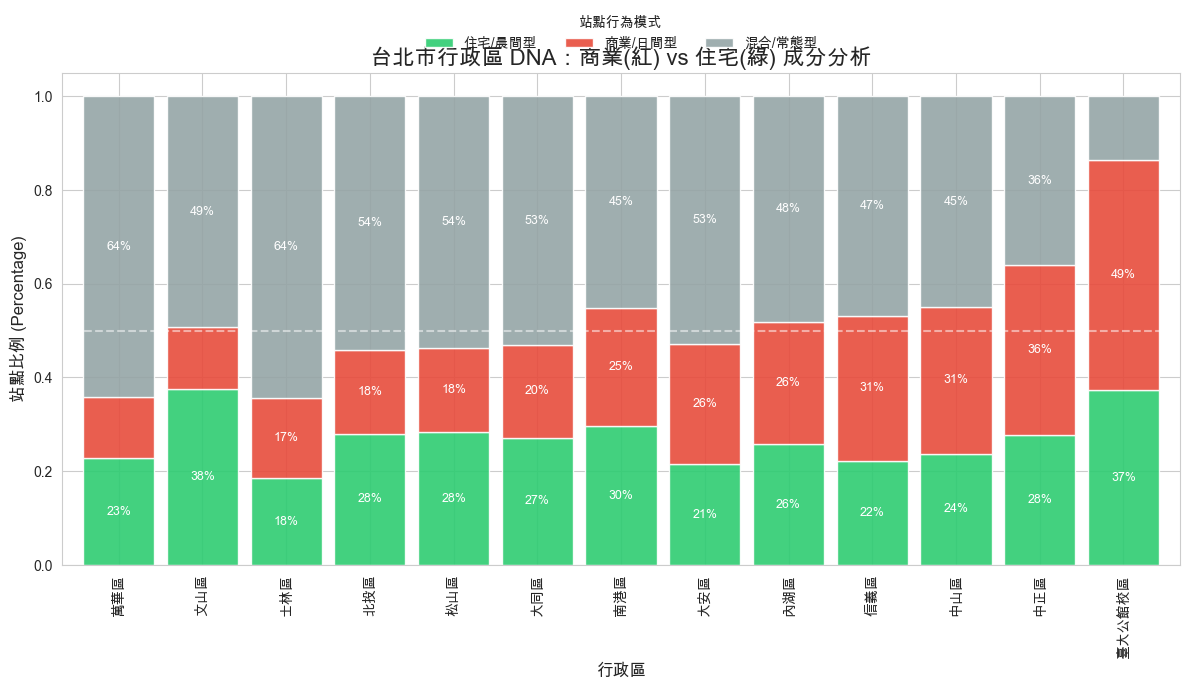

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("\n [Part G ] 行政區解碼")
print("="*60)

# --- 1. K-Means 分群 ---
pivot_table = df_analysis.pivot_table(index='station_no', columns='hour', values='filling_rate', aggfunc='mean').fillna(0)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pivot_table)

# --- 2. 自動命名邏輯 (根據數據校準) ---
cluster_centers = pd.DataFrame(pivot_table.values).groupby(clusters).mean()
cluster_labels = {}

print("AI 自動命名 (校準後)：")
for i in range(4):
    peak_hour = cluster_centers.loc[i].idxmax()
    
    if 10 <= peak_hour <= 17:
        name = "商業/日間型"          # 紅色：白天車多 (辦公室/商圈/校園)
    elif 6 <= peak_hour <= 9:
        name = "住宅/晨間型"          # 綠色：早上被騎走，晚上才回來
    else:
        name = "混合/常態型"          # 灰色：波峰在半夜或不明顯
    
    cluster_labels[i] = name
    print(f"   Cluster {i} (Peak: {peak_hour:02d}:00) -> {name}")

# 回填與合併
station_clusters = pd.DataFrame({'station_no': pivot_table.index, 'Cluster_ID': clusters})
station_clusters['Behavior'] = station_clusters['Cluster_ID'].map(cluster_labels)
station_info = df_analysis[['station_no', 'district']].drop_duplicates()
merged_df = station_clusters.merge(station_info, on='station_no', how='left')

# --- 3. 製作交叉表並排序 ---
cross_tab = pd.crosstab(merged_df['district'], merged_df['Behavior'], normalize='index')

# 排序：依照「商業/日間型」比例由少到多排序
sort_col = "商業/日間型" if "商業/日間型" in cross_tab.columns else cross_tab.columns[0]
cross_tab = cross_tab.sort_values(by=sort_col, ascending=True)

# --- 4. 自定義配色 (紅綠對抗) ---
color_map = {
    "商業/日間型": "#e74c3c",   # 紅色 (Red) - 辦公室、商圈
    "住宅/晨間型": "#2ecc71",   # 綠色 (Green) - 住宅區
    "混合/常態型": "#95a5a6"    # 灰色 (Gray) - 基礎設施
}
plot_colors = [color_map.get(col, "#333333") for col in cross_tab.columns]

# --- 5. 視覺化：堆疊長條圖 ---
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(12, 7), color=plot_colors, width=0.85, alpha=0.9)

plt.title('台北市行政區 DNA：商業(紅) vs 住宅(綠) 成分分析', fontsize=16, fontweight='bold')
plt.xlabel('行政區', fontsize=12)
plt.ylabel('站點比例 (Percentage)', fontsize=12)
plt.legend(title='站點行為模式', bbox_to_anchor=(0.5, 1.02), loc='lower center', ncol=3, frameon=False)
plt.axhline(0.5, color='white', linestyle='--', alpha=0.5)

# 加上數值標籤
for n, x in enumerate([*cross_tab.index.values]):
    cum_y = 0
    for (img, label) in zip(cross_tab.loc[x], cross_tab.loc[x].index):
        if img > 0.15: # 只標示佔比 > 15% 的
            plt.text(n, cum_y + img/2, f"{img:.0%}", ha='center', va='center', color='white', fontsize=9, fontweight='bold')
        cum_y += img

plt.tight_layout()
plt.show()


 [Part D ] 單因子變異數分析：土地分區效應
   資料清洗報告：
   - 剔除異常值：369 筆

 分析樣本摘要：
                       mean       std   count
Zone_Type                                    
Commercial (商業區)   0.361640  0.293170  236609
Mixed (住商混合)       0.385518  0.266800  173027
Residential (住宅區)  0.355214  0.256595  225816


/var/folders/dj/7jjzq_h56x9dgx01j64qw7lc0000gn/T/ipykernel_25690/3679665049.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  esq_sm = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])



 ANOVA 檢定結果：
                    sum_sq        df           F         PR(>F)
C(Zone_Type)     96.669702       2.0  646.338632  3.835516e-281
Residual      47520.496465  635449.0         NaN            NaN

 效果量 (Eta-squared): 0.0020

 Tukey HSD 兩兩比較結果：
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1            group2      meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
Commercial (商業區)      Mixed (住商混合)   0.0239   0.0  0.0219  0.0259   True
Commercial (商業區) Residential (住宅區)  -0.0064   0.0 -0.0083 -0.0045   True
    Mixed (住商混合) Residential (住宅區)  -0.0303   0.0 -0.0324 -0.0283   True
------------------------------------------------------------------------


/var/folders/dj/7jjzq_h56x9dgx01j64qw7lc0000gn/T/ipykernel_25690/3679665049.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Zone_Type', y='filling_rate', data=df_anova,


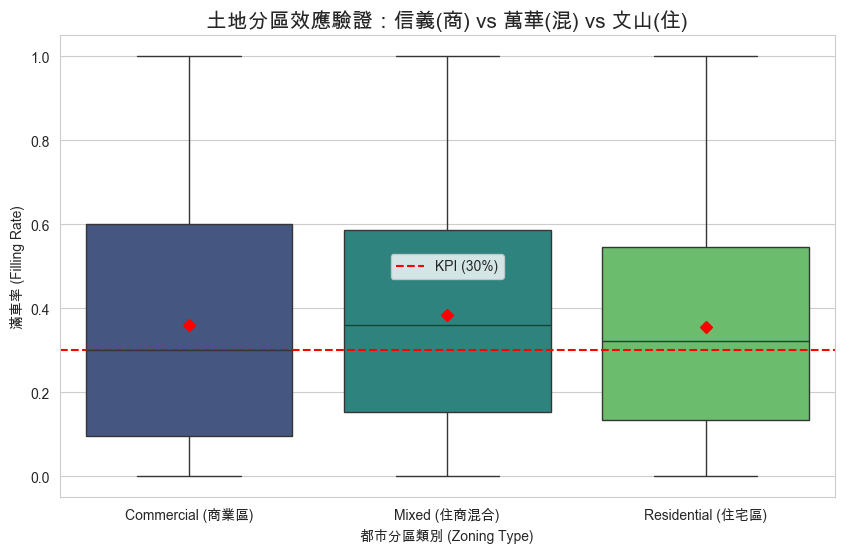

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("\n [Part D ] 單因子變異數分析：土地分區效應")
print("="*60)

# --- 1. 資料準備與清洗 ---
zoning_map = {
    '信義區': 'Commercial (商業區)',  # 代表：CBD
    '萬華區': 'Mixed (住商混合)',      # 代表：舊城區/觀光/居住混合
    '文山區': 'Residential (住宅區)'   # 代表：純住宅
}

# 複製資料
df_anova = df_analysis[df_analysis['district'].isin(zoning_map.keys())].copy()

# 排除異常值
original_count = len(df_anova)
df_anova = df_anova[df_anova['filling_rate'] <= 1.0]
cleaned_count = len(df_anova)

print(f"   資料清洗報告：")
print(f"   - 剔除異常值：{original_count - cleaned_count} 筆")

# 建立分區標籤
df_anova['Zone_Type'] = df_anova['district'].map(zoning_map)

print(f"\n 分析樣本摘要：")
print(df_anova.groupby('Zone_Type')['filling_rate'].agg(['mean', 'std', 'count']))

# --- 2. 執行 ANOVA ---
model = ols('filling_rate ~ C(Zone_Type)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
esq_sm = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])

print("\n ANOVA 檢定結果：")
print(anova_table)
print(f"\n 效果量 (Eta-squared): {esq_sm:.4f}")

# --- 3. 事後檢定 ---
tukey = pairwise_tukeyhsd(endog=df_anova['filling_rate'], 
                          groups=df_anova['Zone_Type'], 
                          alpha=0.05)
print("\n Tukey HSD 兩兩比較結果：")
print(tukey)

# --- 4. 視覺化：分區效應箱型圖 ---
plt.figure(figsize=(10, 6))
# 調整順序，符合光譜：商業 -> 混合 -> 住宅
order_list = ['Commercial (商業區)', 'Mixed (住商混合)', 'Residential (住宅區)']

# Boxplot
sns.boxplot(x='Zone_Type', y='filling_rate', data=df_anova, 
            order=order_list, palette="viridis", showmeans=True, 
            meanprops={"marker":"D", "markerfacecolor":"red", "markeredgecolor":"red"})

plt.title('土地分區效應驗證：信義(商) vs 萬華(混) vs 文山(住)', fontsize=15, fontweight='bold')
plt.ylabel('滿車率 (Filling Rate)')
plt.xlabel('都市分區類別 (Zoning Type)')
plt.axhline(0.3, color='red', linestyle='--', label='KPI (30%)')
plt.ylim(-0.05, 1.05) 
plt.legend()
plt.show()

# 取得平均值
means = df_anova.groupby('Zone_Type')['filling_rate'].mean()
mean_mixed = means['Mixed (住商混合)']
mean_comm = means['Commercial (商業區)']



 [Part E ] 卡方獨立性檢定：缺車風險熱點分析
   分析樣本：3,215,244 筆
   風險定義：滿車率 < 10.0%
------------------------------------------------------------
卡方檢定結果：
• Chi-Square Stat: 35156.0455
• P-value:         0.00000000000000000000000000000000000000000000000000
• Cramér's V:      0.1046
 關聯強度：中等 (Moderate)


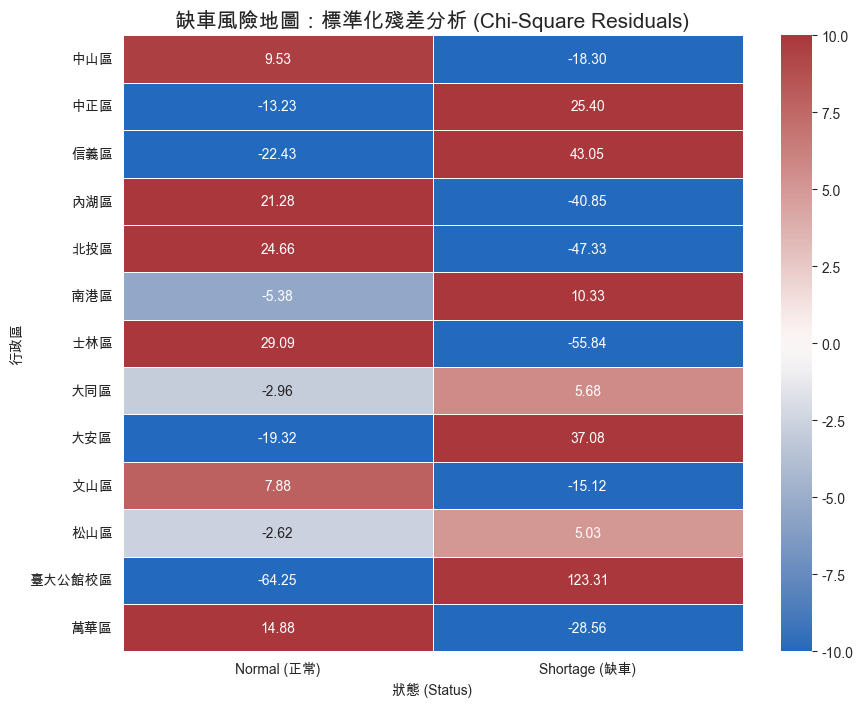

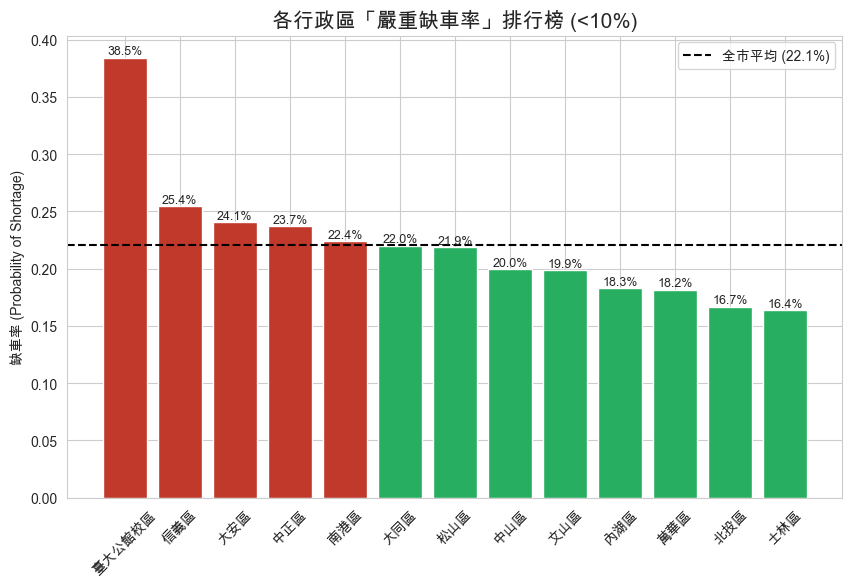


 風險地圖解讀：
1. 紅色警戒區 (Systemic Vulnerability)：
   熱力圖顯示，「臺大公館校區」的缺車殘差高達 123.31。
   這代表該區發生缺車的次數，遠遠超過隨機分佈的預期值，是系統中「最不可靠」的環節。

2. 安全區 (Safety Zone)：
   相對地，「士林區」的殘差為 -55.84 (深藍色)。
   代表該區幾乎很少發生嚴重缺車，車輛周轉與補給最為穩定。

3. 管理建議：
   資源不應齊頭式分配。應將 士林區 的備用調度人力，轉移至 臺大公館校區 進行重點駐點。


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("\n [Part E ] 卡方獨立性檢定：缺車風險熱點分析")
print("="*60)

# --- 1. 資料準備 (定義風險標籤) ---
# 沿用 Part D 的清洗邏輯，確保數據乾淨
df_risk = df_analysis[df_analysis['filling_rate'] <= 1.0].copy()

# 定義「嚴重缺車」：滿車率 < 10%
threshold = 0.1
df_risk['Risk_Label'] = df_risk['filling_rate'].apply(lambda x: 'Shortage (缺車)' if x < threshold else 'Normal (正常)')

print(f"   分析樣本：{len(df_risk):,} 筆")
print(f"   風險定義：滿車率 < {threshold*100}%")
print("-" * 60)

# --- 2. 建立交叉表 (Contingency Table) ---
# 這次我們掃描「全台北市 12 行政區」，看誰是風險王
cross_table = pd.crosstab(df_risk['district'], df_risk['Risk_Label'])

# --- 3. 執行卡方檢定 ---
chi2, p, dof, expected = stats.chi2_contingency(cross_table)

# 計算 Cramér's V (效應量)
n = cross_table.sum().sum()
min_dim = min(cross_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"卡方檢定結果：")
print(f"• Chi-Square Stat: {chi2:.4f}")
print(f"• P-value:         {p:.50f}")
print(f"• Cramér's V:      {cramers_v:.4f}")

if cramers_v < 0.1:
    strength = "微弱 (Weak)"
elif cramers_v < 0.3:
    strength = "中等 (Moderate)"
else:
    strength = "強烈 (Strong)"
print(f" 關聯強度：{strength}")

# --- 4. 關鍵分析：標準化殘差 (Standardized Residuals) ---
# 公式：(觀察值 - 期望值) / sqrt(期望值)
# 這能告訴我們「誰」貢獻了顯著性
residuals = (cross_table - expected) / np.sqrt(expected)

# --- 5. 視覺化：風險殘差熱力圖 (Risk Residual Heatmap) ---
plt.figure(figsize=(10, 8))

# 繪製熱力圖 (紅色代表缺車風險顯著高於預期，藍色代表風險顯著低於預期)
# vmin, vmax 設定為 -5 到 5，因為殘差超過 +/- 1.96 就顯著了，超過 5 代表極度顯著
sns.heatmap(residuals, annot=True, fmt=".2f", cmap="vlag", center=0, vmin=-10, vmax=10, linewidths=.5)

plt.title(f'缺車風險地圖：標準化殘差分析 (Chi-Square Residuals)', fontsize=15, fontweight='bold')
plt.ylabel('行政區')
plt.xlabel('狀態 (Status)')
plt.show()

# --- 6. 補充圖表：缺車率排行榜 (Risk Ranking) ---
# 計算真實的缺車率 (%)
risk_rate = cross_table['Shortage (缺車)'] / cross_table.sum(axis=1)
risk_rank = risk_rate.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#c0392b' if x > risk_rate.mean() else '#27ae60' for x in risk_rank.values]
bars = plt.bar(risk_rank.index, risk_rank.values, color=colors)

# 畫平均線
plt.axhline(risk_rate.mean(), color='black', linestyle='--', label=f'全市平均 ({risk_rate.mean():.1%})')

plt.title('各行政區「嚴重缺車率」排行榜 (<10%)', fontsize=15, fontweight='bold')
plt.ylabel('缺車率 (Probability of Shortage)')
plt.xticks(rotation=45)
plt.legend()

# 標上數值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=9)

plt.show()

# --- 7. 專家洞察 ---
print("\n 風險地圖解讀：")

# 找出殘差最大的缺車區
top_risk_dist = residuals['Shortage (缺車)'].idxmax()
top_risk_val = residuals.loc[top_risk_dist, 'Shortage (缺車)']

# 找出最安全的區
safest_dist = residuals['Shortage (缺車)'].idxmin()
safest_val = residuals.loc[safest_dist, 'Shortage (缺車)']

print(f"1. 紅色警戒區 (Systemic Vulnerability)：")
print(f"   熱力圖顯示，「{top_risk_dist}」的缺車殘差高達 {top_risk_val:.2f}。")
print(f"   這代表該區發生缺車的次數，遠遠超過隨機分佈的預期值，是系統中「最不可靠」的環節。")

print(f"\n2. 安全區 (Safety Zone)：")
print(f"   相對地，「{safest_dist}」的殘差為 {safest_val:.2f} (深藍色)。")
print(f"   代表該區幾乎很少發生嚴重缺車，車輛周轉與補給最為穩定。")

print(f"\n3. 管理建議：")
print(f"   資源不應齊頭式分配。應將 {safest_dist} 的備用調度人力，轉移至 {top_risk_dist} 進行重點駐點。")


 [Part F ] 迴歸模型演化
   建模樣本數：3,213,477 筆 (已移除 > 1.0 的異常感測值)
------------------------------------------------------------


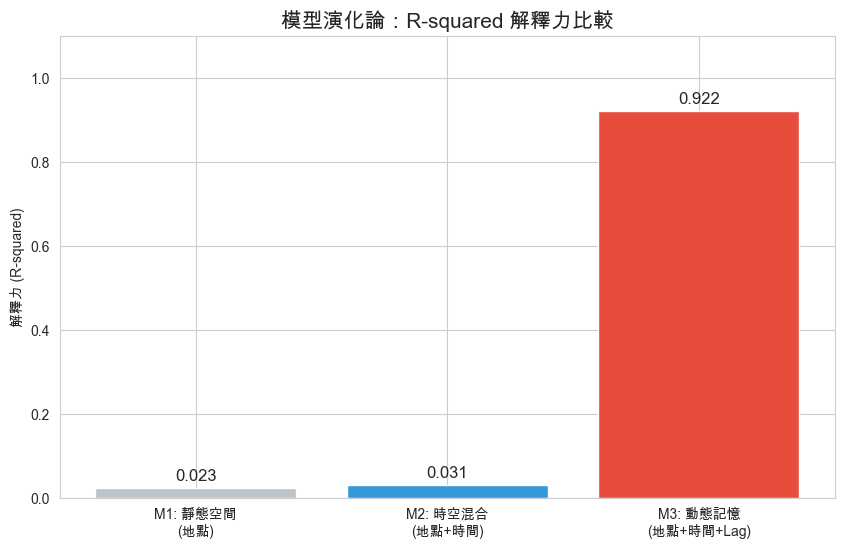

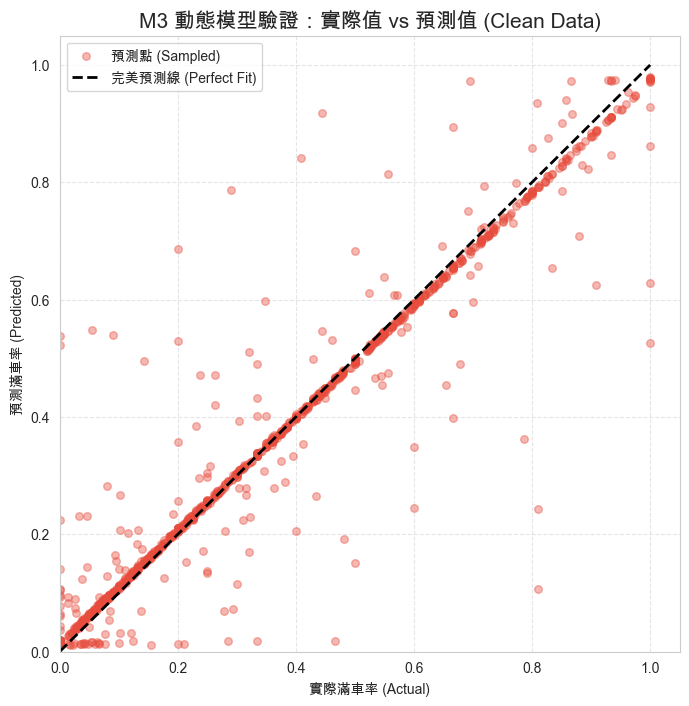

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

print("\n [Part F ] 迴歸模型演化")
print("="*60)

# --- 1. 資料清洗與特徵工程 ---
# A. 排序：確保時間順序正確
df_evo = df_analysis.sort_values(by=['station_no', 'record_time']).copy()

# B. 創造 Lag 變數 (上一刻狀態)
df_evo['filling_rate_lag1'] = df_evo.groupby('station_no')['filling_rate'].shift(1)

# C.  剔除所有異常值 
# 我們只保留 滿車率 0.0 ~ 1.0 之間的合理數據
# 同時也要檢查 lag1 是否合理
df_clean = df_evo[
    (df_evo['filling_rate'] >= 0) & (df_evo['filling_rate'] <= 1.0) &
    (df_evo['filling_rate_lag1'] >= 0) & (df_evo['filling_rate_lag1'] <= 1.0)
].dropna()

# D. 其他變數處理
df_clean['hour_str'] = df_clean['hour'].astype(str)
df_clean['is_weekend'] = df_clean['record_time'].dt.dayofweek >= 5


print(f"   建模樣本數：{len(df_clean):,} 筆 (已移除 > 1.0 的異常感測值)")
print("-" * 60)

# --- 2. 執行三階段模型 (Model Evolution) ---

# Model 1: 空間結構 (地點)
formula_m1 = 'filling_rate ~ dist_to_mrt + total_spaces + C(district)'
model_m1 = smf.ols(formula_m1, data=df_clean).fit()

# Model 2: 時空混合 (地點 + 時間)
formula_m2 = 'filling_rate ~ dist_to_mrt + total_spaces + C(district) + C(hour_str) + is_weekend'
model_m2 = smf.ols(formula_m2, data=df_clean).fit()

# Model 3: 動態預測 (地點 + 時間 + 記憶)
formula_m3 = 'filling_rate ~ dist_to_mrt + total_spaces + C(hour_str) + filling_rate_lag1'
model_m3 = smf.ols(formula_m3, data=df_clean).fit()

# --- 3. 視覺化 A：解釋力大躍進 (Bar Chart) ---
r2_scores = [model_m1.rsquared, model_m2.rsquared, model_m3.rsquared]
models = ['M1: 靜態空間\n(地點)', 'M2: 時空混合\n(地點+時間)', 'M3: 動態記憶\n(地點+時間+Lag)']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, r2_scores, color=['#bdc3c7', '#3498db', '#e74c3c'])

# 標上數值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('模型演化論：R-squared 解釋力比較', fontsize=15, fontweight='bold')
plt.ylabel('解釋力 (R-squared)')
plt.ylim(0, 1.1)
plt.show()

# --- 4. 視覺化 B：M3 預測準確度 (Scatter Plot) ---
# 隨機抽樣 1000 點來畫圖，避免過度擁擠
sample_viz = df_clean.sample(1000, random_state=42)
pred_vals = model_m3.predict(sample_viz)

plt.figure(figsize=(8, 8))

# 畫散佈點
plt.scatter(sample_viz['filling_rate'], pred_vals, 
            alpha=0.4, s=30, color='#e74c3c', label='預測點 (Sampled)')

# 畫完美預測線 (45度線)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='完美預測線 (Perfect Fit)')

plt.title('M3 動態模型驗證：實際值 vs 預測值 (Clean Data)', fontsize=15, fontweight='bold')
plt.xlabel('實際滿車率 (Actual)')
plt.ylabel('預測滿車率 (Predicted)')
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()